We explored the method of empirical Bayes estimation for all basketball players, even for the ones with 0 goals out of 1 attempt. But we can't only reply on a single value for each player. We would want to know how much uncertainty is present in our estimate. 

In many cases, statisticians would use a binomial proportion confidence interval, but this doesn't bring in information from our whole dataset. We will compute a credible interval which is similar to the confidence intervals but improved one.

In [1]:
import os
import math
import pandas as pd
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
project_dir = '/mnt/data-ubuntu/Projects/statistics_python3'
df = pd.read_csv(project_dir + '/data/nba-players-stats/seasons_stats_pg.csv')

In [3]:
data = df.loc[:,'2P%'][(df.loc[:,'2P%']<1) & (df.loc[:,'2P%']>0)]
beta_fit = beta.fit(data = data, floc=0, fscale=1)
a = round(beta_fit[0], 2)
b = round(beta_fit[1], 2)
print(f'a: {a},b: {b}')
df.head()

a: 23.05,b: 29.35


,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high
0,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,0.343504,166.05,317.35,0.301850,0.386385
1,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,0.361986,340.05,599.35,0.331557,0.392972
2,1950.0,Dick McGuire*,PG,190.0,563.0,0.337478,0.346198,213.05,402.35,0.309128,0.384214
3,1950.0,Fred Scolari,PG,312.0,910.0,0.342857,0.348140,335.05,627.35,0.318365,0.378513
4,1950.0,George Senesky,PG,227.0,709.0,0.320169,0.328408,250.05,511.35,0.295510,0.362160


## Calculate the credible interval
We start with a prior distribution, then update to a
posterior distribution(Beta Distribution). 
$B(a + hits, b + misses)$. The math can be found [here](https://en.wikipedia.org/wiki/Conjugate_prior#Example)

In [4]:
# Calculate the credible interval based on each player's a and b
# We set a credible interval at 95%.
df['a_i'] = df.loc[: ,'2P'] + a
df['b_i'] = df.loc[: ,'2PA']-df.loc[: ,'2P'] + b
df['low'] = df.apply(lambda x: beta.ppf(0.025, x.a_i, x.b_i, loc=0, scale=1), axis = 1)
df['high'] = df.apply(lambda x: beta.ppf(0.975, x.a_i, x.b_i, loc=0, scale=1), axis = 1)
df.to_csv(project_dir + '/data/nba-players-stats/seasons_stats_pg.csv', index = False)
df.head()

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high
0,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,0.343504,166.05,317.35,0.301850,0.386385
1,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,0.361986,340.05,599.35,0.331557,0.392972
2,1950.0,Dick McGuire*,PG,190.0,563.0,0.337478,0.346198,213.05,402.35,0.309128,0.384214
3,1950.0,Fred Scolari,PG,312.0,910.0,0.342857,0.348140,335.05,627.35,0.318365,0.378513
4,1950.0,George Senesky,PG,227.0,709.0,0.320169,0.328408,250.05,511.35,0.295510,0.362160


In [5]:
# Lets select 5 players and compare their performance
df_5 = df.iloc[[1,200,800,2000,3000], :]
# Calculate interviels.
error = df_5 \
    .loc[:, ['2P%_estimate', 'low','high']]
error['low'] = error.loc[:, 'low'] - error.loc[:, '2P%_estimate']
error['high'] = error.loc[:, 'high'] - error.loc[:, '2P%_estimate']
error = error.loc[:, ['low','high']]

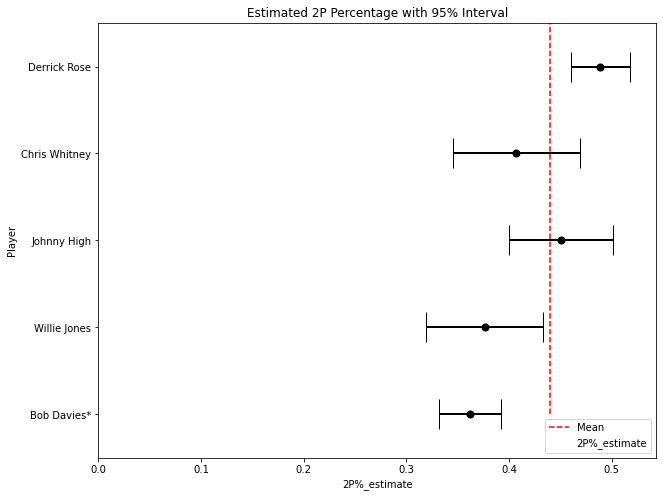

In [6]:
# Plot the credible intervals
fig,ax = plt.subplots(figsize=(10, 8))

df_5 \
    .set_index('Player') \
    .loc[:, '2P%_estimate'] \
    .plot(kind = 'barh',
          alpha = 0,
          ax = ax,
          xerr = error.values.T,
          error_kw = {'capsize':15, 'elinewidth':2})

df_5 \
    .plot(y = 'Player',
          x = '2P%_estimate',
          color = 'black',
          kind = 'scatter',
          s = 50,
          ax = ax)

y = np.linspace(0, 5, 1000)
x = [(a/(a+b))] * len(y)
plt.plot(x, y, linestyle='--',color = 'red', label='Mean') 
plt.title('Estimated 2P Percentage with 95% Interval')
legend = ax.legend(loc='lower right')
plt.show()